In [1]:
import numpy as np
import matplotlib.pyplot as plt
from preprocess import load_data_and_preprocess

tracks = load_data_and_preprocess()

Loading datasets...
Preprocessing tracks...


In [2]:
from metrics import MetricsEvaluation
from concurrent.futures import ThreadPoolExecutor
from baseline_script import FeatureType
from audio_irsystem import AudioIRSystem
from diversity_rerank import DiversityRerank

# sample 1000 tracks
np.random.seed(42)
tracks = np.random.choice(tracks, 2500, replace=False)

audio_ir_musicnn = AudioIRSystem(tracks, feature_type='musicnn').set_name("Audio-MusicNN")
evaluation_protocol = MetricsEvaluation(tracks)

# perform grid search for diversity and store results
tasks = []
multiples = [1, 2, 3,4, 5,6,7,8,9, 10]
diversification_options = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for pool_multiple in multiples:
    for diversification in diversification_options:
        system = DiversityRerank(tracks, audio_ir_musicnn, diversification=diversification,
                                    dissimilarity_feature=FeatureType.TFIDF, pool_multiple=pool_multiple).set_name(
            f"Audio-MusicNN-Diversification-{diversification}-{FeatureType.TFIDF}")
        tasks.append((f"Audio-MusicNN-Diversification-{diversification}-{FeatureType.TFIDF}", pool_multiple, diversification, system))


diversity_results = np.zeros((len(multiples), len(diversification_options)))
ndcg_results = np.zeros((len(multiples), len(diversification_options)))
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(evaluation_protocol.evaluate, ir_system) for _, _, _, ir_system in tasks]
    for (name, pool_multiple, diversification, _), future in zip(tasks, futures):
        metrics = future.result()
        diversity_results[multiples.index(pool_multiple), diversification_options.index(diversification)] = metrics["Diversity"]
        ndcg_results[multiples.index(pool_multiple), diversification_options.index(diversification)] = metrics["NDCG@10"]

[Audio-MusicNN-Diversification-0.05-FeatureType.TFIDF] Progress: 0.00%[Audio-MusicNN-Diversification-0.1-FeatureType.TFIDF] Progress: 0.00%

[Audio-MusicNN-Diversification-0.15-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.2-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.25-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.3-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.35-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.4-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.45-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.5-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.05-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.1-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.15-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicNN-Diversification-0.2-FeatureType.TFIDF] Progress: 0.00%
[Audio-MusicN

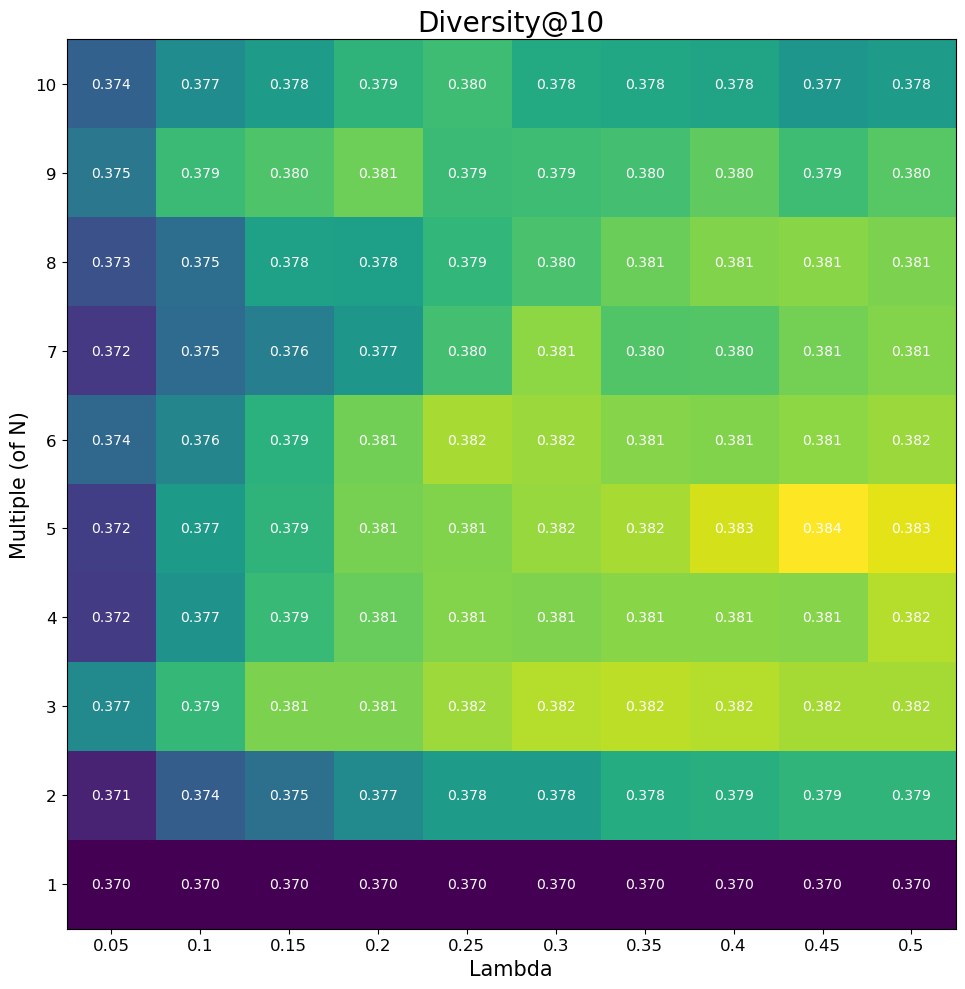

In [30]:

# min max normalization
normalized_diversity_results = (diversity_results - diversity_results.min()) / (diversity_results.max() - diversity_results.min())
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(diversity_results)

# Show all ticks and label them with the respective list entries
ax.set_yticks(range(len(multiples)), labels=multiples)
ax.set_ylabel("Multiple (of N)")
ax.invert_yaxis()

ax.set_xticks(range(len(diversification_options)), labels=diversification_options)
ax.set_xlabel("Lambda")
ax.tick_params(axis='both', which='major', labelsize=12)


ax.yaxis.get_label().set_fontsize(15)
ax.xaxis.get_label().set_fontsize(15)

# Loop over data dimensions and create text annotations.
for i in range(len(diversification_options)):
    for j in range(len(multiples)):
        result = diversity_results[i, j]
        # rount to 3 decimal places
        text = ax.text(j, i, f"{result:.3f}",
                       ha="center", va="center", color="w")

ax.set_title("Diversity@10")
ax.title.set_size(20)

fig.tight_layout()
plt.show()

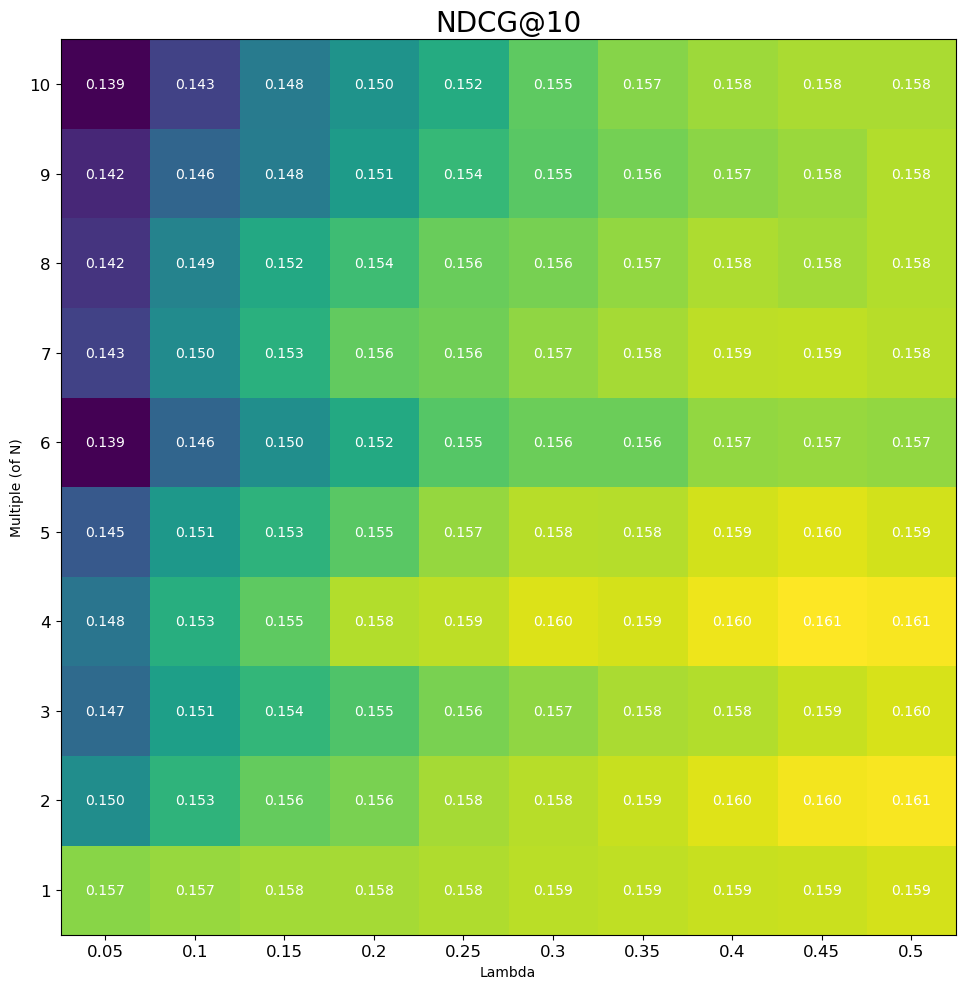

In [31]:

# min max normalization
normalized_ndcg_results = (ndcg_results - ndcg_results.min()) / (ndcg_results.max() - ndcg_results.min())
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ndcg_results)

# Show all ticks and label them with the respective list entries
ax.set_yticks(range(len(multiples)), labels=multiples)
ax.set_ylabel("Multiple (of N)")
ax.invert_yaxis()
ax.set_xticks(range(len(diversification_options)), labels=diversification_options)
ax.set_xlabel("Lambda")
ax.tick_params(axis='both', which='major', labelsize=12)


# Loop over data dimensions and create text annotations.
for i in range(len(diversification_options)):
    for j in range(len(multiples)):
        result = ndcg_results[i, j]
        # rount to 3 decimal places
        text = ax.text(j, i, f"{result:.3f}",
                       ha="center", va="center", color="w")

ax.set_title("NDCG@10")
ax.title.set_size(20)
fig.tight_layout()
plt.show()